In [1]:
import os
import glob
import shutil
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# PyTorch imports
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# sklearn imports for classification, clustering, and metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    silhouette_score,
)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split



# Oxford Pets Data Set 

In [2]:
full_data = r"C:\Data\images"

# Functions needed

In [3]:
def GMM(data, n_clusters = 3):
    
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(data)
    
    return gmm_labels

def GMM_means(data, n_clusters = 3):
    
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(data)
    
    return gmm.means_

def sil_score(data, cluster_labels, cluster_type):
    
    score = silhouette_score(data, cluster_labels, metric='euclidean')
    
    print(f"Silhouette Score for {cluster_type} : {score:.3f}")

def plot_clusters(data, labels, title, feature_labels):
    
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, s=10)
    plt.xlabel(f'{feature_labels} 1')
    plt.ylabel(f'{feature_labels} 2')
    plt.title(title)
    plt.grid(True)
    plt.show()

In [4]:
# Functions used down the Pipeline

def evaluate(feature_extractor, fc_layer, dataloader):
    feature_extractor.eval()  # Set feature extractor to evaluation mode
    fc_layer.eval()           # Set fully connected layer to evaluation mode
    correct_predictions = 0

    with torch.no_grad():  # No gradient calculations needed
        for images, labels in dataloader:
            # Move images and labels to the device
            images, labels = images.to(device), labels.to(device)

            # Extract features using the feature extractor
            features = feature_extractor(images)
            features = features.flatten(start_dim=1)  # Flatten the features

            # Forward pass through the FC layer
            outputs = fc_layer(features)
            _, preds = torch.max(outputs, 1)  # Get predicted class
            correct_predictions += torch.sum(preds == labels)  # Compare with true labels

    # Calculate accuracy
    accuracy = correct_predictions.double() / len(dataloader.dataset)
    return accuracy.item()

## Test Dataset for training

In [5]:
Cat_or_Dog = r"C:\Data\CatorDog"
Breeds_Full_Path = r"C:/Data/full_organised_breeds1"

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalisation for ImageNet
])


### CAT OR DOG TRAIN

In [6]:
# Load the full dataset
full_dataset = datasets.ImageFolder(root=Cat_or_Dog, transform=transform)

# Split dataset into 80% train and 20% test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader_Binary = DataLoader(test_dataset, batch_size=32, shuffle=False)

### FULL 37 BREEDS TRAIN

In [7]:
# Load the full dataset
full_dataset = datasets.ImageFolder(root=Breeds_Full_Path, transform=transform)

# Split dataset into 80% train and 20% test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader_Breeds = DataLoader(test_dataset, batch_size=32, shuffle=False)

### CUDA

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# I have cuda so alot of features and labels will be moved to GPU for acceleration

Using device: cuda


## 37 folders for breeds

In [9]:
# =============================================================================
# """# Organised Breeds Folder"""
# =============================================================================

# Surface
#Organised_Breeds = r"C:\Users\moham\OneDrive - Lancaster University\Modules\SCC403 Data Mining\Final Project\Data\oxford-iiit-pet\images.tar\images\Organised_Sample"

full_data = r"C:\Data\images"

full_organised = r'C:\Data\full_organised_breeds1'
# List of all breeds
breeds = [
    "Abyssinian", "Bengal", "Bombay", "Birman", "British_Shorthair",
    "Egyptian_Mau","Maine_Coon", "Persian", "Ragdoll" ,"Russian_Blue", "Siamese", "Sphynx",
    "American_Bulldog", "American_Pit_Bull_Terrier", "Basset_Hound", "Beagle",
    "Boxer", "Chihuahua", "English_Cocker_Spaniel", "English_Setter",
    "German_Shorthair", "Great_Pyrenees", "Havanese", "Japanese_Chin",
    "Keeshond", "Leonberger", "Miniature_Pinscher", "Newfoundland",
    "Pomeranian", "Pug", "Saint_Bernard", "Samoyed", "Scottish_Terrier",
    "Shiba_Inu", "Staffordshire_Bull_Terrier", "Wheaten_Terrier", "Yorkshire_Terrier"
]

## 2 folders for cats and dogs

In [10]:
# =============================================================================
#  """ Create subfolders for all breeds """
# =============================================================================
for breed in breeds:
    os.makedirs(os.path.join(full_organised, breed), exist_ok=True)

# copy images into their respective breed folders
for file_name in os.listdir(full_data):
    for breed in breeds:
        # Check if the breed name is in the file name (case-insensitive)
        if breed.lower() in file_name.lower():
            source_path = os.path.join(full_data, file_name)
            destination_path = os.path.join(full_organised, breed, file_name)  # Move to breed folder
            shutil.copy(source_path, destination_path)  # Move the file
            break

## Labels CSV

In [11]:
# =============================================================================
# """# Labels CSV"""
# =============================================================================
# Step 1: Load the Labels CSV
csv_path = r"C:\Data\all_columns.csv"
labels_df = pd.read_csv(csv_path)



labels_df.head()
len(labels_df)

7390

# Cat or Dog Section

In [12]:
dataset_path = r"C:\Data\images"
folder_names = os.listdir(dataset_path)

cat_or_dog_labels = dict(zip(labels_df['Breed'], labels_df['Species']))
cat_or_dog = {}
for folder in folder_names:
    if folder in cat_or_dog_labels:
        cat_or_dog[folder] = cat_or_dog_labels[folder]

## Resnet 18

In [13]:
# =============================================================================
# """# ResNet Model"""
# =============================================================================
start_time = time.time()

# Dataset path
dataset_path = r"C:\Data\CatorDog"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalisation for ImageNet
])

# Load the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

cat_dog_values = list(dataset.class_to_idx.keys())  # ['Cat', 'Dog']
print("Custom labels from dict_values:", cat_dog_values)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load ResNet-18 pre-trained on ImageNet
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet18.eval()  # Set to evaluation mode

# Remove the fully connected layer to use ResNet as a feature extractor
feature_extractor = torch.nn.Sequential(*list(resnet18.children())[:-1])
feature_extractor = feature_extractor.to(device)  # Move feature extractor to GPU

# Extract features and assign labels
all_features1 = []
all_labels1 = []

with torch.no_grad():  # No gradients needed for feature extraction
    for inputs, targets in data_loader:
        inputs = inputs.to(device)  # Move inputs to GPU

        # Extract features
        features = feature_extractor(inputs)
        features = features.flatten(start_dim=1)
        all_features1.append(features)

        # Map numeric labels to string labels
        D_C_labels = [cat_dog_values[target.item()] for target in targets]
        all_labels1.extend(D_C_labels)

# Combine features into a single tensor
all_features1 = torch.cat(all_features1, dim=0)

# need to convert back so I can see clusters
all_features1 = all_features1.cpu()

# Print results
print("Feature tensor shape:", all_features1.shape)
print("First 10 custom labels:", all_labels1[:10])

end_time = time.time()
print(f"Cell runtime: {end_time - start_time:.0f} seconds")

Custom labels from dict_values: ['cat', 'dog']
Feature tensor shape: torch.Size([7390, 512])
First 10 custom labels: ['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat']
Cell runtime: 17 seconds


In [15]:
# Map class names ('cat', 'dog') to numerical labels (0, 1)
class_to_idx = dataset.class_to_idx  # {'cat': 0, 'dog': 1}

# Convert all_labels1 to numerical labels
all_labels1_numeric = [class_to_idx[label] for label in all_labels1]

C:\Users\Mohammed Ameen Dasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mohammed Ameen Dasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


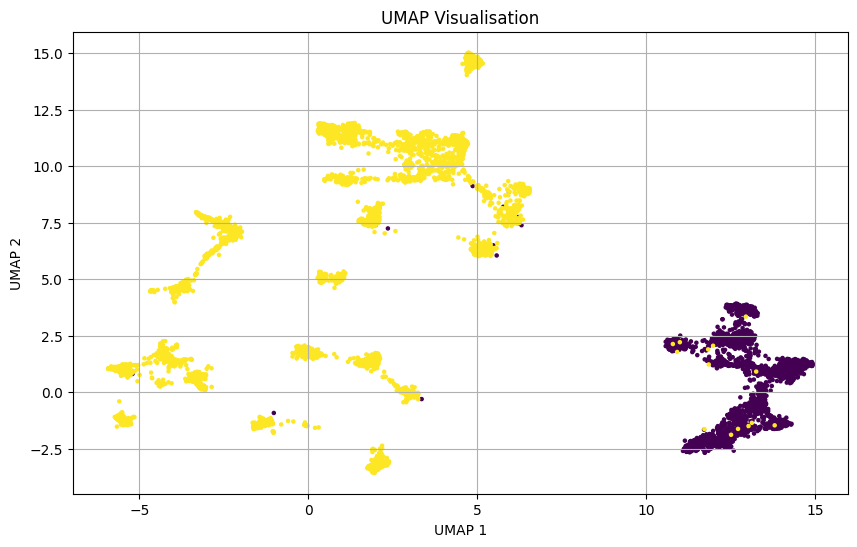

Silhouette Score for GMM : 0.577


In [16]:
import umap
import matplotlib.pyplot as plt

# Apply UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_features = umap_reducer.fit_transform(all_features1)

# Visualise UMAP
plt.figure(figsize=(10, 6))
plt.scatter(umap_features[:, 0], umap_features[:, 1], c=all_labels1_numeric, s=5)
plt.title("UMAP Visualisation")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()

sil_score(umap_features, GMM(umap_features, 2), "GMM")

In [17]:
import torch

# Save to a file
torch.save((all_features1, all_labels1_numeric), "OxfordIII_Cat_or_Dog.pth")
print("Features and labels saved successfully!")

Features and labels saved successfully!


### Training a Fully Connected Layer (Resnet - 18) 

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load precomputed features and labels
features_cat_dog, labels_cat_dog = torch.load("OxfordIII_Cat_or_Dog.pth", weights_only=True)

features_cat_dog = torch.tensor(features_cat_dog).to(device)  # Move features to GPU
labels_cat_dog = torch.tensor(labels_cat_dog).to(device)      # Move labels to GPU

# Create a DataLoader for training
dataset = TensorDataset(features_cat_dog, labels_cat_dog)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the fully connected layer
num_classes = 2
input_dim = features_cat_dog.shape[1]  # Dimension of the extracted features
fc_layer_cat_dog = nn.Linear(input_dim, num_classes).to(device)  # Move model to GPU

# Define optimiser and loss function
optimiser = optim.Adam(fc_layer_cat_dog.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)  # Move loss function to GPU 

# Training loop
num_epochs = 10
fc_layer_cat_dog.train()  # Set to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0  # Initialise correct predictions counter for each epoch

    for inputs, targets in data_loader:
        # Move inputs and targets to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = fc_layer_cat_dog(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()

        # Calculate predictions and accuracy
        _, preds = torch.max(outputs, 1)  # Get the predicted class indices
        correct_predictions += torch.sum(preds == targets).item()

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = correct_predictions / len(dataset)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Save the trained layer
torch.save(fc_layer_cat_dog.state_dict(), "trained_fc_layer_cat_dog.pth")
print("Trained fully connected layer saved.")

C:\Users\Mohammed Ameen Dasu\AppData\Local\Temp\ipykernel_3372\2757544111.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features_cat_dog = torch.tensor(features_cat_dog).to(device)  # Move features to GPU


Epoch [1/10], Loss: 0.0887, Accuracy: 0.9716
Epoch [2/10], Loss: 0.0324, Accuracy: 0.9916
Epoch [3/10], Loss: 0.0250, Accuracy: 0.9928
Epoch [4/10], Loss: 0.0216, Accuracy: 0.9931
Epoch [5/10], Loss: 0.0205, Accuracy: 0.9936
Epoch [6/10], Loss: 0.0176, Accuracy: 0.9939
Epoch [7/10], Loss: 0.0158, Accuracy: 0.9961
Epoch [8/10], Loss: 0.0143, Accuracy: 0.9966
Epoch [9/10], Loss: 0.0136, Accuracy: 0.9961
Epoch [10/10], Loss: 0.0133, Accuracy: 0.9961
Trained fully connected layer saved.


In [19]:
# Move the trained FC layer to the GPU
fc_layer_cat_dog.eval()  
# Set the layer to evaluation mode

# Move features to the GPU
features_cat_dog = features_cat_dog.to(device)

# Extract refined features
with torch.no_grad():  # No gradients needed for inference
    res_tuned = fc_layer_cat_dog(features_cat_dog).cpu().numpy()  # Move results to CPU for further processing

# Print the shape of the refined features
print("Refined features shape:", res_tuned.shape)

Refined features shape: (7390, 2)


In [20]:
# So the Refined features are in --> res_tuned --> later we will test these results

## VGG - 16

In [21]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Dataset path
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for VGG16
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalisation for ImageNet
])
dataset_path = r"C:\Data\CatorDog"

# Load the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Use `dict_values` directly
#breed_values = list(dataset.class_to_idx.keys())  # Get your custom labels
#print("Custom labels from dict_values:", breed_values)

cat_dog_values = list(dataset.class_to_idx.keys())  # ['Cat', 'Dog']
print("Custom labels from dict_values:", cat_dog_values)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load VGG16 pre-trained on ImageNet
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
vgg16 = vgg16.to(device)  # Move model to GPU
vgg16.eval()  # Set to evaluation mode

# Remove the fully connected layers to use VGG16 as a feature extractor
vgg_feature_extractor = torch.nn.Sequential(*list(vgg16.features.children()))
vgg_feature_extractor = vgg_feature_extractor.to(device)  # Move feature extractor to GPU

# Extract features and assign labels, CDV --> CAT DOG VGG16
CDV_features = []
CDV_labels = []

with torch.no_grad():  # No gradients needed for feature extraction
    for inputs, targets in data_loader:
        # Move inputs to GPU
        inputs = inputs.to(device)

        # Extract features
        features = vgg_feature_extractor(inputs)
        features = features.flatten(start_dim=1)  # Flatten the spatial dimensions
        CDV_features.append(features)

        # Directly use dict_values to assign labels
        CDV_labels.extend(targets.numpy().tolist())  # Use numeric indices directly

# Combine features into a single tensor
CDV_features = torch.cat(CDV_features, dim=0)

# Move features to CPU if needed for further processing
CDV_features = CDV_features.cpu()

# Print results
print("Feature tensor shape:", CDV_features.shape)
print("First 10 custom labels:", CDV_labels[:10])

Custom labels from dict_values: ['cat', 'dog']
Feature tensor shape: torch.Size([7390, 25088])
First 10 custom labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


C:\Users\Mohammed Ameen Dasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mohammed Ameen Dasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


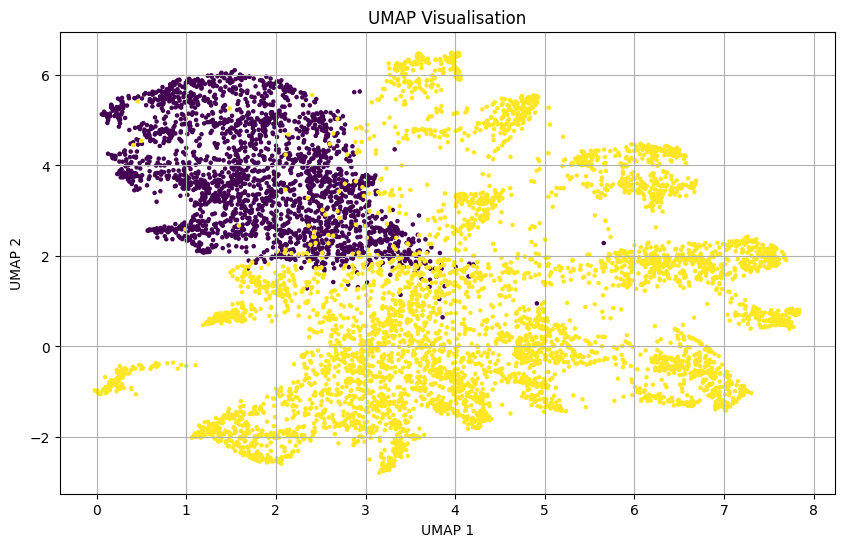

Silhouette Score for GMM : 0.428


In [22]:
import umap
import matplotlib.pyplot as plt

# Apply UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_features = umap_reducer.fit_transform(CDV_features)

# Visualise UMAP
plt.figure(figsize=(10, 6))
plt.scatter(umap_features[:, 0], umap_features[:, 1], c=all_labels1_numeric, s=5)
plt.title("UMAP Visualisation")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()

sil_score(umap_features, GMM(umap_features, 2), "GMM")

In [23]:
import torch

# Save extracted features and labels
torch.save((CDV_features, CDV_labels), "CDV_OxfordIII.pth")
print("Features and labels saved.")

Features and labels saved.


### Training a Fully Connected Layer

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load precomputed features and labels
features_vgg_cd, labels_vgg_cd = torch.load("CDV_OxfordIII.pth", weights_only=True)

features_vgg_cd = torch.tensor(features_vgg_cd).to(device)  # Move features to GPU
labels_vgg_cd = torch.tensor(labels_vgg_cd).to(device)      # Move labels to GPU

# Create a DataLoader for training
dataset = TensorDataset(features_vgg_cd, labels_cat_dog)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the fully connected layer
num_classes = 2
input_dim = features_vgg_cd.shape[1]  # Dimension of the extracted features
vgg_binary = nn.Linear(input_dim, num_classes).to(device)  # Move model to GPU

# Define optimiser and loss function
optimiser = optim.Adam(vgg_binary.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)  # Move loss function to GPU 

# Training loop
num_epochs = 10
vgg_binary.train()  # Set to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0  # Initialise correct predictions counter for each epoch

    for inputs, targets in data_loader:
        # Move inputs and targets to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = vgg_binary(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()

        # Calculate predictions and accuracy
        _, preds = torch.max(outputs, 1)  # Get the predicted class indices
        correct_predictions += torch.sum(preds == targets).item()

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = correct_predictions / len(dataset)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Save the trained layer
torch.save(vgg_binary.state_dict(), "trained_vgg_binary_OxfordIII.pth")
print("Trained fully connected layer saved.")

C:\Users\Mohammed Ameen Dasu\AppData\Local\Temp\ipykernel_3372\1091153760.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features_vgg_cd = torch.tensor(features_vgg_cd).to(device)  # Move features to GPU


Epoch [1/10], Loss: 0.1267, Accuracy: 0.9765
Epoch [2/10], Loss: 0.0179, Accuracy: 0.9954
Epoch [3/10], Loss: 0.0108, Accuracy: 0.9972
Epoch [4/10], Loss: 0.0071, Accuracy: 0.9978
Epoch [5/10], Loss: 0.0047, Accuracy: 0.9988
Epoch [6/10], Loss: 0.0002, Accuracy: 0.9999
Epoch [7/10], Loss: 0.0057, Accuracy: 0.9989
Epoch [8/10], Loss: 0.0101, Accuracy: 0.9974
Epoch [9/10], Loss: 0.0125, Accuracy: 0.9977
Epoch [10/10], Loss: 0.0132, Accuracy: 0.9991
Trained fully connected layer saved.


In [25]:
# Move the trained FC layer to the GPU
vgg_binary.eval()  
# Set the layer to evaluation mode

# Move features to the GPU
features_vgg_cd = features_vgg_cd.to(device)

# Extract refined features
with torch.no_grad():  # No gradients needed for inference
    VGG_tuned_Binary = vgg_binary(features_vgg_cd).cpu().numpy()  # Move results to CPU for further processing

# Print the shape of the refined features
print("Refined features shape:", VGG_tuned_Binary.shape)

Refined features shape: (7390, 2)


In [26]:
# So the Refined features are in --> VGG_tuned_Binary --> later we will test these results

# Classification

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## Resnet 18 Classification

### Before Training

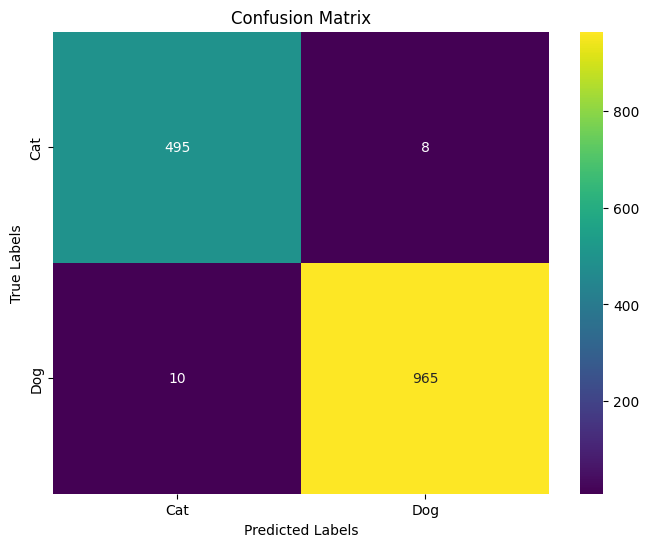


Classification Report:
               precision    recall  f1-score   support

         Cat       0.98      0.98      0.98       503
         Dog       0.99      0.99      0.99       975

    accuracy                           0.99      1478
   macro avg       0.99      0.99      0.99      1478
weighted avg       0.99      0.99      0.99      1478



In [28]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Convert features and labels to NumPy arrays
res_features_np = all_features1.numpy()
res_labels_np = np.array(all_labels1)

# Train-Test split
from sklearn.model_selection import train_test_split
cat_dog_features_train, cat_dog_features_test, cat_dog_labels_train, cat_dog_labels_test = train_test_split(res_features_np, res_labels_np, test_size=0.2, random_state=42)

# Train an SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(cat_dog_features_train, cat_dog_labels_train)

# Make predictions
cat_dog_predictions  = svm.predict(cat_dog_features_test)

# Class names
class_names = ['Cat', 'Dog']
plot_confusion_matrix(cat_dog_labels_test,cat_dog_predictions, class_names)

# Print classification report
print("\nClassification Report:\n", classification_report(cat_dog_labels_test, cat_dog_predictions, target_names=class_names))


### After training

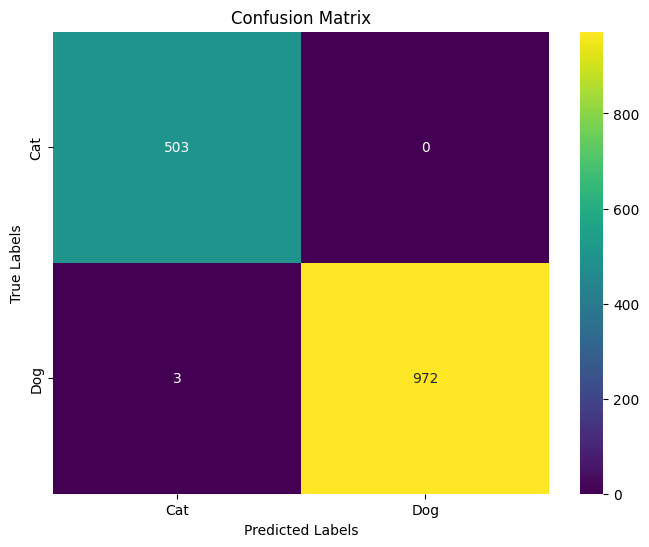


Classification Report:
               precision    recall  f1-score   support

         Cat       0.99      1.00      1.00       503
         Dog       1.00      1.00      1.00       975

    accuracy                           1.00      1478
   macro avg       1.00      1.00      1.00      1478
weighted avg       1.00      1.00      1.00      1478



In [29]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

#features_cat_dog = features_cat_dog.cpu()
labels_cat_dog = labels_cat_dog.cpu()
# Convert features and labels to NumPy arrays
res_features_np1 = res_tuned
res_labels_np1 = np.array(labels_cat_dog)

# Train-Test split
from sklearn.model_selection import train_test_split
cat_dog_features_train, cat_dog_features_test, cat_dog_labels_train, cat_dog_labels_test = train_test_split(res_features_np1, res_labels_np1, test_size=0.2, random_state=42)

# Train an SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(cat_dog_features_train, cat_dog_labels_train)

# Make predictions
cat_dog_predictions  = svm.predict(cat_dog_features_test)

# Class names
class_names = ['Cat', 'Dog']
plot_confusion_matrix(cat_dog_labels_test,cat_dog_predictions, class_names)

# Print classification report
print("\nClassification Report:\n", classification_report(cat_dog_labels_test, cat_dog_predictions, target_names=class_names))

## VGG - 16 Classification

### Before Training

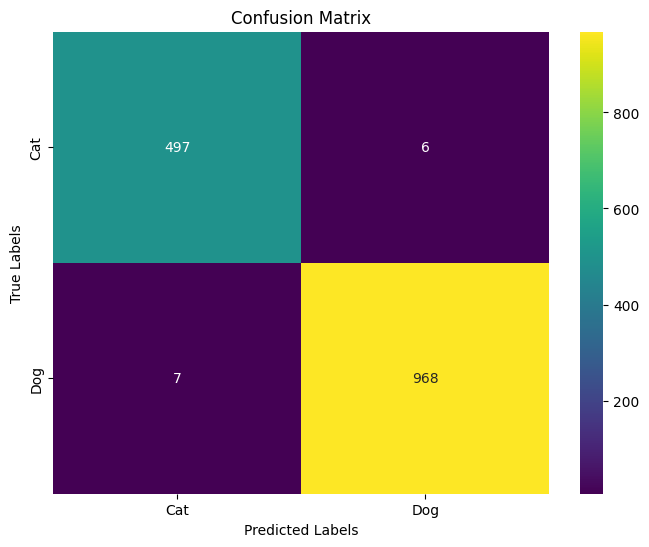


Classification Report:
               precision    recall  f1-score   support

         Cat       0.99      0.99      0.99       503
         Dog       0.99      0.99      0.99       975

    accuracy                           0.99      1478
   macro avg       0.99      0.99      0.99      1478
weighted avg       0.99      0.99      0.99      1478



In [30]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Convert features and labels to NumPy arrays
VGG_features_np = CDV_features.numpy()
VGG_labels_np = np.array(CDV_features)

# Train-Test split
from sklearn.model_selection import train_test_split
cat_dog_features_train, cat_dog_features_test, cat_dog_labels_train, cat_dog_labels_test = train_test_split(VGG_features_np, res_labels_np, test_size=0.2, random_state=42)

# Train an SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(cat_dog_features_train, cat_dog_labels_train)

# Make predictions
cat_dog_predictions  = svm.predict(cat_dog_features_test)

# Class names
class_names = ['Cat', 'Dog']
plot_confusion_matrix(cat_dog_labels_test,cat_dog_predictions, class_names)

# Print classification report
print("\nClassification Report:\n", classification_report(cat_dog_labels_test, cat_dog_predictions, target_names=class_names))

### After Training

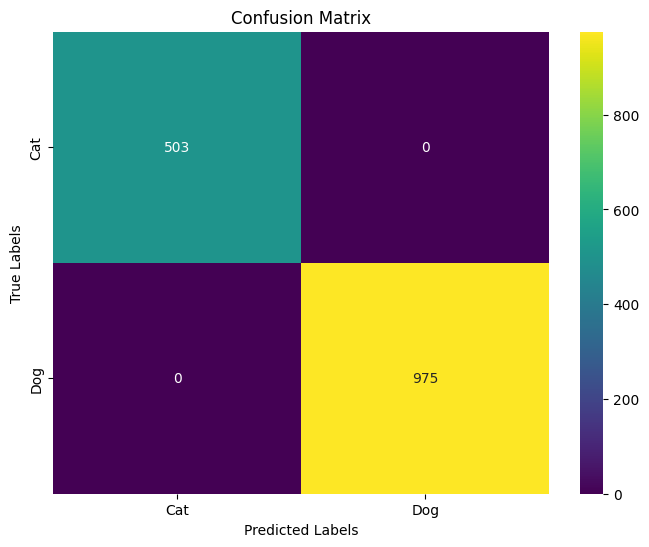


Classification Report:
               precision    recall  f1-score   support

         Cat       1.00      1.00      1.00       503
         Dog       1.00      1.00      1.00       975

    accuracy                           1.00      1478
   macro avg       1.00      1.00      1.00      1478
weighted avg       1.00      1.00      1.00      1478



In [31]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

#features_vgg_cd = features_vgg_cd.cpu()
labels_vgg_cd = labels_vgg_cd.cpu()
# Convert features and labels to NumPy arrays
VGG_features_np1 = VGG_tuned_Binary
VGG_labels_np1 = np.array(labels_vgg_cd)

# Train-Test split
from sklearn.model_selection import train_test_split
cat_dog_features_train, cat_dog_features_test, cat_dog_labels_train, cat_dog_labels_test = train_test_split(VGG_features_np1, VGG_labels_np1, test_size=0.2, random_state=42)

# Train an SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(cat_dog_features_train, cat_dog_labels_train)

# Make predictions
cat_dog_predictions  = svm.predict(cat_dog_features_test)

# Class names
class_names = ['Cat', 'Dog']
plot_confusion_matrix(cat_dog_labels_test,cat_dog_predictions, class_names)

# Print classification report
print("\nClassification Report:\n", classification_report(cat_dog_labels_test, cat_dog_predictions, target_names=class_names))

# Full 37 Breeds

## Resnet 18 Full 37 Breeds

In [32]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

dataset_path = r"C:/Data/full_organised_breeds1"
folder_names = os.listdir(dataset_path)

folder_to_label = dict(zip(labels_df['Breed'], labels_df['Class ID']))
mapped_labels = {}
for folder in folder_names:
    if folder in folder_to_label:
        mapped_labels[folder] = folder_to_label[folder]

In [33]:
import time
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Start timer
start_time = time.time()

# Dataset path
dataset_path = r'C:/Data/full_organised_breeds1'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalisation for ImageNet
])

# Load the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Get custom labels
breed_values = list(dataset.class_to_idx.keys())
print("Custom labels from dict_values:", breed_values)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load ResNet-18 pre-trained on ImageNet
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet18.eval()  # Set to evaluation mode

# Remove the fully connected layer to use ResNet as a feature extractor
feature_extractor_resnet = torch.nn.Sequential(*list(resnet18.children())[:-1])

# Extract features and assign labels
res_breed_features = []
res_breed_labels = []

with torch.no_grad():  # No gradients needed for feature extraction
    for inputs, targets in data_loader:
        # Forward pass through feature extractor
        features = feature_extractor_resnet(inputs)
        features = features.flatten(start_dim=1)
        res_breed_features.append(features)  # Keep features on CPU

        # Convert targets to custom labels
        custom_labels = [breed_values[target.item()] for target in targets]
        res_breed_labels.extend(custom_labels)

# Combine features into a single tensor
res_breed_features = torch.cat(res_breed_features, dim=0)

# Print results
print("Feature tensor shape:", res_breed_features.shape)
print("First 10 custom labels:", res_breed_labels[:10])

# End timer
end_time = time.time()
print(f"Cell runtime: {end_time - start_time:.0f} seconds")

Custom labels from dict_values: ['Abyssinian', 'American_Bulldog', 'American_Pit_Bull_Terrier', 'Basset_Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British_Shorthair', 'Chihuahua', 'Egyptian_Mau', 'English_Cocker_Spaniel', 'English_Setter', 'German_Shorthair', 'Great_Pyrenees', 'Havanese', 'Japanese_Chin', 'Keeshond', 'Leonberger', 'Maine_Coon', 'Miniature_Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian_Blue', 'Saint_Bernard', 'Samoyed', 'Scottish_Terrier', 'Shiba_Inu', 'Siamese', 'Sphynx', 'Staffordshire_Bull_Terrier', 'Wheaten_Terrier', 'Yorkshire_Terrier']
Feature tensor shape: torch.Size([7390, 512])
First 10 custom labels: ['Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian']
Cell runtime: 96 seconds


In [36]:
# Map class names ( breed ) to numerical labels (0, 36)
class_to_idx = dataset.class_to_idx  

# Convert all_labels1 to numerical labels
res_breed_labels_numeric = [class_to_idx[label] for label in res_breed_labels]

In [37]:
import torch

# Save to a file
torch.save((res_breed_features, res_breed_labels_numeric), "OxfordIII_Breeds.pth")
print("Features and labels saved successfully!")

Features and labels saved successfully!


### Training an FC Resent 18 Layer

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load precomputed features and labels
features, labels = torch.load("OxfordIII_Breeds.pth", weights_only=True)

features_res_breeds = torch.tensor(features)
labels_res_breeds = torch.tensor(labels)
# Create a DataLoader for training
dataset = TensorDataset(features_res_breeds, labels_res_breeds)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Load ResNet-18 pre-trained on ImageNet
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Remove the last fully connected layer (fc)
feature_extractor = nn.Sequential(*list(resnet18.children())[:-1])

# Freeze the feature extractor
for param in feature_extractor.parameters():
    param.requires_grad = False

# Define the fully connected layer
num_classes = 37
input_dim = features_res_breeds.shape[1]  # Dimension of the extracted features
fc_layer = nn.Linear(input_dim, num_classes)

# Define optimiser and loss function
optimiser = optim.Adam(fc_layer.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
fc_layer.train()  # Set to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0  # Initialise correct predictions counter for each epoch

    for inputs, targets in data_loader:
        # Forward pass
        outputs = fc_layer(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()

        # Calculate predictions and accuracy
        _, preds = torch.max(outputs, 1)  # Get the predicted class indices
        correct_predictions += torch.sum(preds == targets).item()

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = correct_predictions / len(dataset) 

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

resnet18.fc = fc_layer

# Save the trained layer
torch.save(resnet18.fc.state_dict(), 'trained_fc_layerq.pth')
print("Trained fully connected layer saved.")

C:\Users\Mohammed Ameen Dasu\AppData\Local\Temp\ipykernel_3372\2020380437.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features_res_breeds = torch.tensor(features)


Epoch [1/10], Loss: 1.1433, Accuracy: 0.7390
Epoch [2/10], Loss: 0.3951, Accuracy: 0.9015
Epoch [3/10], Loss: 0.2965, Accuracy: 0.9240
Epoch [4/10], Loss: 0.2454, Accuracy: 0.9334
Epoch [5/10], Loss: 0.2121, Accuracy: 0.9432
Epoch [6/10], Loss: 0.1884, Accuracy: 0.9490
Epoch [7/10], Loss: 0.1651, Accuracy: 0.9563
Epoch [8/10], Loss: 0.1483, Accuracy: 0.9614
Epoch [9/10], Loss: 0.1337, Accuracy: 0.9675
Epoch [10/10], Loss: 0.1223, Accuracy: 0.9693
Trained fully connected layer saved.


In [39]:
# Move the trained FC layer to the GPU
fc_layer = fc_layer.to(device)
fc_layer.eval()  
# Set the layer to evaluation mode

# Move features to the GPU
features_res_breeds = features_res_breeds.to(device)

# Extract refined features
with torch.no_grad():  # No gradients needed for inference
    Refined_Resnet_breeds = fc_layer(features_res_breeds).cpu().numpy()  # Move results to CPU for further processing

# Print the shape of the refined features
print("Refined features shape:", Refined_Resnet_breeds.shape)

Refined features shape: (7390, 37)


## VGG - 16 Full 37 Breeds

In [71]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Dataset path
dataset_path = r'C:/Data/full_organised_breeds1'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for VGG16
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalisation for ImageNet
])

# Load the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Use `dict_values` directly
breed_values = list(dataset.class_to_idx.keys())  # Get your custom labels
print("Custom labels from dict_values:", breed_values)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load VGG16 pre-trained on ImageNet
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
vgg16.eval()  # Set to evaluation mode

# Remove the fully connected layers to use VGG16 as a feature extractor
feature_extractor_vgg = torch.nn.Sequential(*list(vgg16.features.children()))

# Extract features and assign labels
vgg_features = []
vgg_labels = []

with torch.no_grad():  # No gradients needed for feature extraction
    for inputs, targets in data_loader:
        # Extract features
        features = feature_extractor_vgg(inputs)
        features = features.flatten(start_dim=1)  # Flatten the spatial dimensions
        vgg_features.append(features)

        # Directly use dict_values to assign labels
        custom_labels = [breed_values[target.item()] for target in targets]
        
        vgg_labels.extend(targets.numpy().tolist())  # Use numeric indices directly

# Combine features into a single tensor
vgg_features = torch.cat(vgg_features, dim=0)

# Print results
print("Feature tensor shape:", vgg_features.shape)
print("First 10 custom labels:", vgg_labels[:10])

Custom labels from dict_values: ['Abyssinian', 'American_Bulldog', 'American_Pit_Bull_Terrier', 'Basset_Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British_Shorthair', 'Chihuahua', 'Egyptian_Mau', 'English_Cocker_Spaniel', 'English_Setter', 'German_Shorthair', 'Great_Pyrenees', 'Havanese', 'Japanese_Chin', 'Keeshond', 'Leonberger', 'Maine_Coon', 'Miniature_Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian_Blue', 'Saint_Bernard', 'Samoyed', 'Scottish_Terrier', 'Shiba_Inu', 'Siamese', 'Sphynx', 'Staffordshire_Bull_Terrier', 'Wheaten_Terrier', 'Yorkshire_Terrier']
Feature tensor shape: torch.Size([7390, 25088])
First 10 custom labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [48]:
import torch

# Save extracted features and labels
torch.save((vgg_features, vgg_labels), "features_and_labels.pth")
print("Features and labels saved.")

Features and labels saved.


### Tranining an FC VGG - 16 Layer

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load precomputed features and labels
features_VGG_breeds, labels_VGG_breeds = torch.load("features_and_labels.pth", weights_only=True)

# Convert labels to tensor format (if not already)
labels_VGG_breeds = torch.tensor(labels_VGG_breeds)

# Create a DataLoader for training
dataset = TensorDataset(features_VGG_breeds, labels_VGG_breeds)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the fully connected layer
num_classes = 37  # Replace with your actual number of classes
input_dim = features_VGG_breeds.shape[1]  # Dimension of the extracted features
vgg_layer = nn.Linear(input_dim, num_classes)

# Define optimiser and loss function
optimiser = optim.Adam(vgg_layer.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
vgg_layer.train()  # Set to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0  # Initialise correct predictions counter for each epoch

    for inputs, targets in data_loader:
        # Forward pass
        outputs = vgg_layer(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()

        # Calculate predictions and accuracy
        _, preds = torch.max(outputs, 1)  # Get the predicted class indices
        correct_predictions += torch.sum(preds == targets).item()

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = correct_predictions / len(dataset) 

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


# Save the trained layer
torch.save(vgg_layer.state_dict(), "trained_vgg_layer.pth")
print("Trained fully connected layer saved.")

Epoch [1/10], Loss: 1.7787, Accuracy: 0.7419
Epoch [2/10], Loss: 0.2981, Accuracy: 0.9522
Epoch [3/10], Loss: 0.1216, Accuracy: 0.9775
Epoch [4/10], Loss: 0.1112, Accuracy: 0.9829
Epoch [5/10], Loss: 0.1065, Accuracy: 0.9801
Epoch [6/10], Loss: 0.1543, Accuracy: 0.9767
Epoch [7/10], Loss: 0.1284, Accuracy: 0.9816
Epoch [8/10], Loss: 0.1344, Accuracy: 0.9815
Epoch [9/10], Loss: 0.1504, Accuracy: 0.9805
Epoch [10/10], Loss: 0.1253, Accuracy: 0.9844
Trained fully connected layer saved.


In [50]:
# Determine the device of the model
vgg_layer = vgg_layer.to(device)
vgg_layer.eval()  
# Set the layer to evaluation mode

# Move features to the GPU
features_VGG_breeds = features_VGG_breeds.to(device)

# Extract refined features
with torch.no_grad():  # No gradients needed for inference
    VGG_tuned_breeds = vgg_layer(features_VGG_breeds).cpu().numpy()  # Move results to CPU for further processing

# Print the shape of the refined features
print("Refined features shape:", VGG_tuned_breeds.shape)

Refined features shape: (7390, 37)


# Classification

## Resnet 18 Classification 

### Before Training

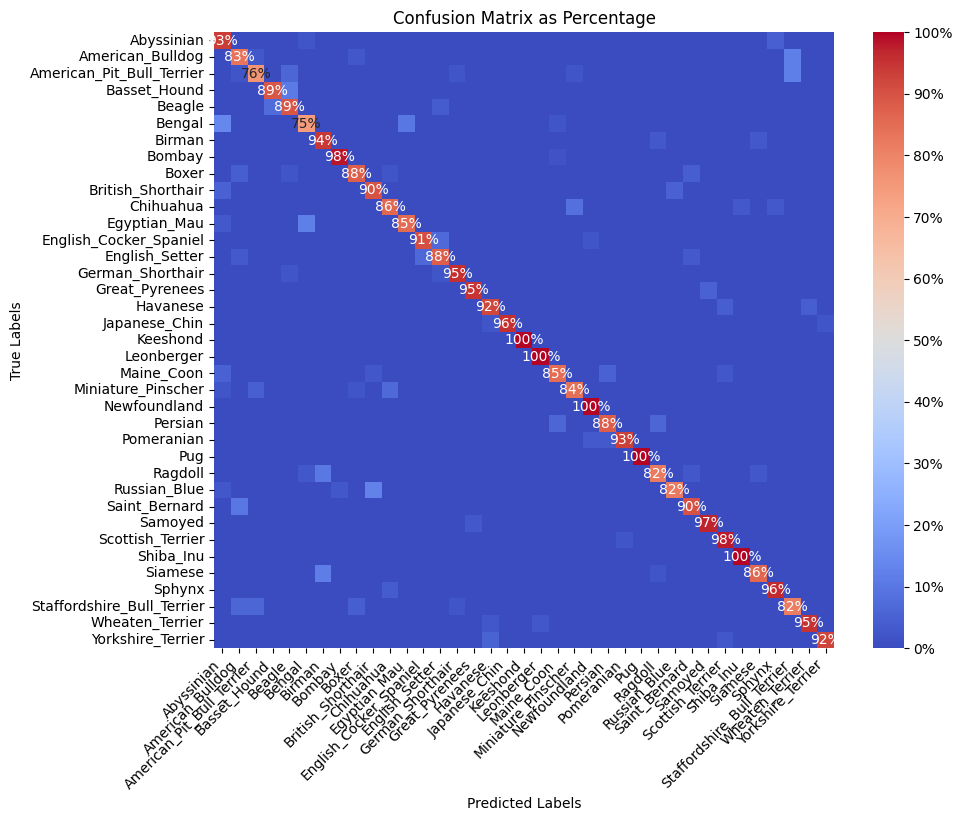


Classification Report:
                             precision    recall  f1-score   support

                Abyssinian       0.75      0.93      0.83        46
          American_Bulldog       0.78      0.83      0.80        42
 American_Pit_Bull_Terrier       0.87      0.76      0.81        51
              Basset_Hound       0.94      0.89      0.92        37
                    Beagle       0.74      0.89      0.81        28
                    Bengal       0.86      0.75      0.80        51
                    Birman       0.79      0.94      0.86        35
                    Bombay       0.98      0.98      0.98        55
                     Boxer       0.91      0.88      0.89        48
         British_Shorthair       0.86      0.90      0.88        40
                 Chihuahua       0.86      0.86      0.86        36
              Egyptian_Mau       0.85      0.85      0.85        34
    English_Cocker_Spaniel       0.95      0.91      0.93        43
            English_Se

In [51]:
# Convert features and labels to NumPy arrays
res_features_np = res_breed_features.numpy()
res_labels_np = np.array(res_breed_labels)

# Train-Test split
from sklearn.model_selection import train_test_split
cat_dog_features_train, cat_dog_features_test, cat_dog_labels_train, cat_dog_labels_test = train_test_split(
    res_features_np, res_labels_np, test_size=0.2, random_state=42)

# Train an SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(cat_dog_features_train, cat_dog_labels_train)

# Make predictions
cat_dog_predictions = svm.predict(cat_dog_features_test)

# Confusion Matrix
cm = confusion_matrix(cat_dog_labels_test, cat_dog_predictions)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Percentage normalisation
cm_percentage = np.nan_to_num(cm_percentage, nan=0.0)  # Handle NaN rows

class_names = breed_values

# Annotate only diagonal cells
annotations = np.empty_like(cm_percentage, dtype=object)
for i in range(cm_percentage.shape[0]):
    for j in range(cm_percentage.shape[1]):
        annotations[i, j] = f"{float(cm_percentage[i, j]):.0f}%" if i == j else ""

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=annotations, cmap="coolwarm", fmt='', xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'format': '%.0f%%', 'ticks': [i for i in range(0, 101, 10)]}, vmax=100, vmin=0)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Confusion Matrix as Percentage")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# Print classification report
print("\nClassification Report:\n", classification_report(cat_dog_labels_test, cat_dog_predictions, target_names=class_names))

### After Training

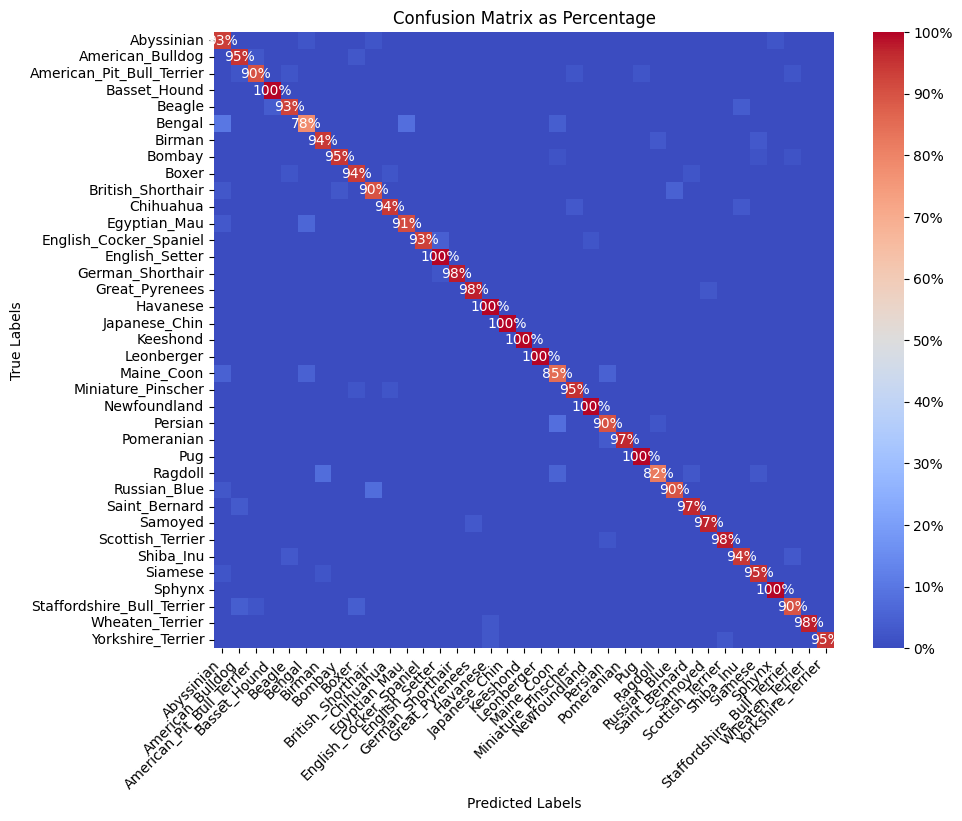


Classification Report:
                             precision    recall  f1-score   support

                Abyssinian       0.80      0.93      0.86        46
          American_Bulldog       0.91      0.95      0.93        42
 American_Pit_Bull_Terrier       0.96      0.90      0.93        51
              Basset_Hound       0.97      1.00      0.99        37
                    Beagle       0.90      0.93      0.91        28
                    Bengal       0.89      0.78      0.83        51
                    Birman       0.89      0.94      0.92        35
                    Bombay       0.98      0.95      0.96        55
                     Boxer       0.92      0.94      0.93        48
         British_Shorthair       0.90      0.90      0.90        40
                 Chihuahua       0.94      0.94      0.94        36
              Egyptian_Mau       0.89      0.91      0.90        34
    English_Cocker_Spaniel       1.00      0.93      0.96        43
            English_Se

In [52]:
# Convert features and labels to NumPy arrays
res_features_np1 = Refined_Resnet_breeds
res_labels_np1   = np.array(labels_res_breeds)

# Train-Test split
from sklearn.model_selection import train_test_split
cat_dog_features_train, cat_dog_features_test, cat_dog_labels_train, cat_dog_labels_test = train_test_split(
    res_features_np1, res_labels_np1, test_size=0.2, random_state=42)

# Train an SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(cat_dog_features_train, cat_dog_labels_train)

# Make predictions
cat_dog_predictions = svm.predict(cat_dog_features_test)

# Confusion Matrix
cm = confusion_matrix(cat_dog_labels_test, cat_dog_predictions)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Percentage normalisation
cm_percentage = np.nan_to_num(cm_percentage, nan=0.0)  # Handle NaN rows

class_names = breed_values

# Annotate only diagonal cells
annotations = np.empty_like(cm_percentage, dtype=object)
for i in range(cm_percentage.shape[0]):
    for j in range(cm_percentage.shape[1]):
        annotations[i, j] = f"{float(cm_percentage[i, j]):.0f}%" if i == j else ""

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=annotations, cmap="coolwarm", fmt='', xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'format': '%.0f%%', 'ticks': [i for i in range(0, 101, 10)]}, vmax=100, vmin=0)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Confusion Matrix as Percentage")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Print classification report
print("\nClassification Report:\n", classification_report(cat_dog_labels_test, cat_dog_predictions, target_names=class_names))

## VGG - 16 Classification

### Before Training

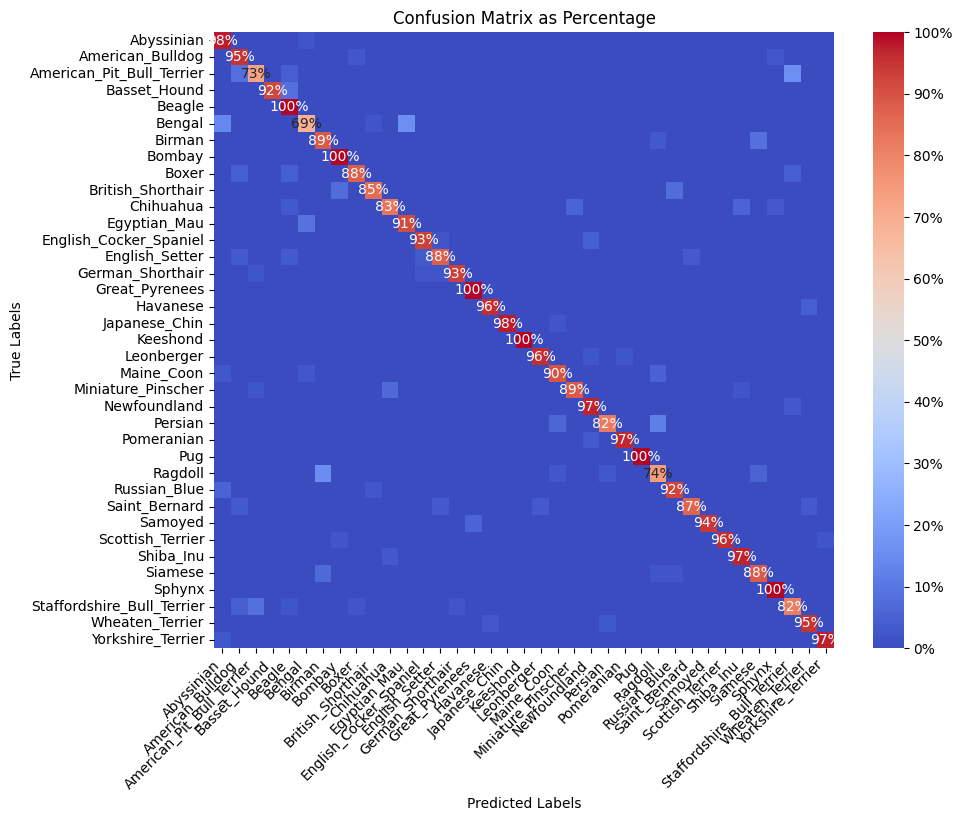


Classification Report:
                             precision    recall  f1-score   support

                Abyssinian       0.80      0.98      0.88        46
          American_Bulldog       0.80      0.95      0.87        42
 American_Pit_Bull_Terrier       0.86      0.73      0.79        51
              Basset_Hound       1.00      0.92      0.96        37
                    Beagle       0.74      1.00      0.85        28
                    Bengal       0.88      0.69      0.77        51
                    Birman       0.78      0.89      0.83        35
                    Bombay       0.93      1.00      0.96        55
                     Boxer       0.95      0.88      0.91        48
         British_Shorthair       0.94      0.85      0.89        40
                 Chihuahua       0.88      0.83      0.86        36
              Egyptian_Mau       0.79      0.91      0.85        34
    English_Cocker_Spaniel       0.95      0.93      0.94        43
            English_Se

In [53]:
# Convert features and labels to NumPy arrays if needed
VGG_features = vgg_features.numpy()
VGG_labels   = np.array(vgg_labels)

# Train-Test split
from sklearn.model_selection import train_test_split
cat_dog_features_train, cat_dog_features_test, cat_dog_labels_train, cat_dog_labels_test = train_test_split(
    VGG_features, VGG_labels, test_size=0.2, random_state=42)

# Train an SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(cat_dog_features_train, cat_dog_labels_train)

# Make predictions
cat_dog_predictions = svm.predict(cat_dog_features_test)

# Confusion Matrix
cm = confusion_matrix(cat_dog_labels_test, cat_dog_predictions)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Percentage normalisation
cm_percentage = np.nan_to_num(cm_percentage, nan=0.0)  # Handle NaN rows

class_names = breed_values

# Annotate only diagonal cells
annotations = np.empty_like(cm_percentage, dtype=object)
for i in range(cm_percentage.shape[0]):
    for j in range(cm_percentage.shape[1]):
        annotations[i, j] = f"{float(cm_percentage[i, j]):.0f}%" if i == j else ""

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=annotations, cmap="coolwarm", fmt='', xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'format': '%.0f%%', 'ticks': [i for i in range(0, 101, 10)]}, vmax=100, vmin=0)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Confusion Matrix as Percentage")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Print classification report
print("\nClassification Report:\n", classification_report(cat_dog_labels_test, cat_dog_predictions, target_names=class_names))

### After Training

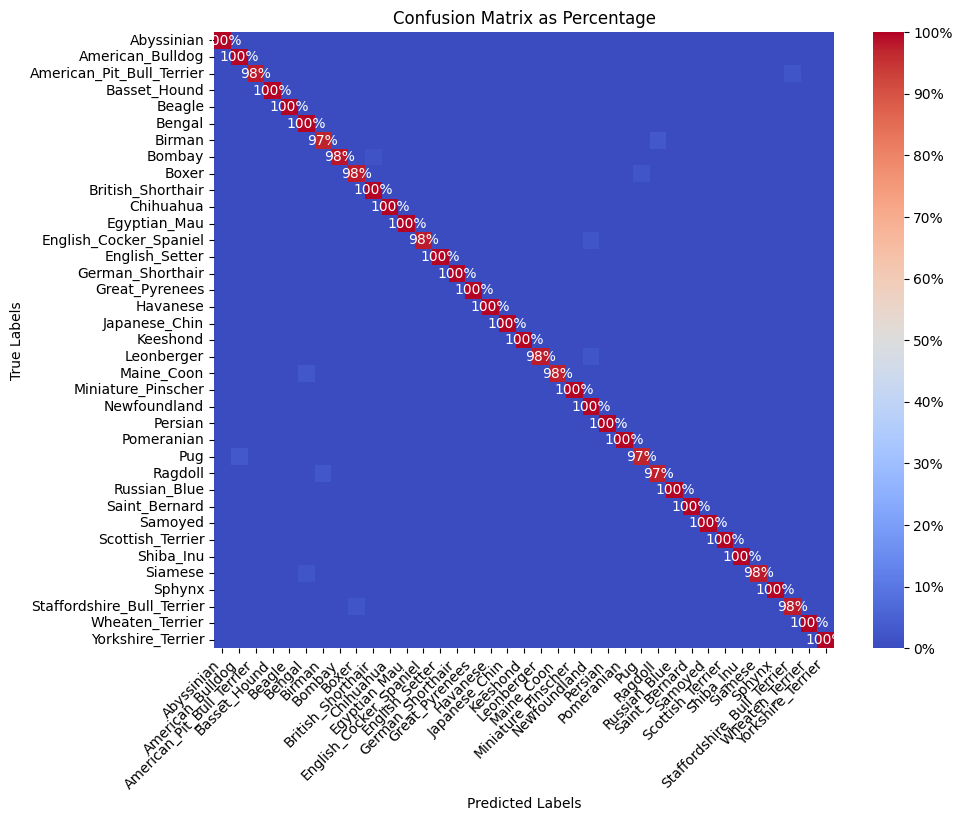


Classification Report:
                             precision    recall  f1-score   support

                Abyssinian       1.00      1.00      1.00        46
          American_Bulldog       0.98      1.00      0.99        42
 American_Pit_Bull_Terrier       1.00      0.98      0.99        51
              Basset_Hound       1.00      1.00      1.00        37
                    Beagle       1.00      1.00      1.00        28
                    Bengal       0.96      1.00      0.98        51
                    Birman       0.97      0.97      0.97        35
                    Bombay       1.00      0.98      0.99        55
                     Boxer       0.98      0.98      0.98        48
         British_Shorthair       0.98      1.00      0.99        40
                 Chihuahua       1.00      1.00      1.00        36
              Egyptian_Mau       1.00      1.00      1.00        34
    English_Cocker_Spaniel       1.00      0.98      0.99        43
            English_Se

In [54]:
# Convert features and labels to NumPy arrays if needed
VGG_features = VGG_tuned_breeds
VGG_labels   = np.array(vgg_labels)

# Train-Test split
from sklearn.model_selection import train_test_split
cat_dog_features_train, cat_dog_features_test, cat_dog_labels_train, cat_dog_labels_test = train_test_split(
    VGG_features, VGG_labels, test_size=0.2, random_state=42)

# Train an SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(cat_dog_features_train, cat_dog_labels_train)

# Make predictions
cat_dog_predictions = svm.predict(cat_dog_features_test)

# Confusion Matrix
cm = confusion_matrix(cat_dog_labels_test, cat_dog_predictions)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Percentage normalisation
cm_percentage = np.nan_to_num(cm_percentage, nan=0.0)  # Handle NaN rows

class_names = breed_values

# Annotate only diagonal cells
annotations = np.empty_like(cm_percentage, dtype=object)
for i in range(cm_percentage.shape[0]):
    for j in range(cm_percentage.shape[1]):
        annotations[i, j] = f"{float(cm_percentage[i, j]):.0f}%" if i == j else ""

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=annotations, cmap="coolwarm", fmt='', xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'format': '%.0f%%', 'ticks': [i for i in range(0, 101, 10)]}, vmax=100, vmin=0)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Confusion Matrix as Percentage")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Print classification report
print("\nClassification Report:\n", classification_report(cat_dog_labels_test, cat_dog_predictions, target_names=class_names))

# My own Tests

## Resnet 18 

### Before Train

In [55]:
# Define preprocessing (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match normalisation
])

# Load pretrained ResNet as feature extractor
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
feature_extractor = torch.nn.Sequential(*list(resnet18.children())[:-1])  # Remove FC layer
resnet18.eval()

# Train SVM with precomputed features and labels
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(res_breed_features, res_breed_labels)

# Path to your test folder
folder_path = 'C:/Data/my_test'

# Initialise variables for test images
test_image_features = []
test_image_names = []

# Preprocess and extract features for each image in the test folder
for image_name in os.listdir(folder_path):
    image_path = os.path.join(folder_path, image_name)
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filter valid image files
        image = Image.open(image_path).convert("RGB")  # Convert to RGB
        image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            features = feature_extractor(image_tensor).flatten(start_dim=1).numpy()
        test_image_features.append(features)
        test_image_names.append(image_name)

# Combine features into a single array
test_image_features = np.vstack(test_image_features)  # Shape: (n_samples, feature_dim)

# Predict probabilities for all test images
probabilities = svm.predict_proba(test_image_features)

# Get class names
class_names = np.unique(res_breed_labels)  # Unique class names from training labels

# Print probabilities for each test image
# Print top 3 class probabilities for each test image
for image_name, probs in zip(test_image_names, probabilities):
    print(f"Image: {image_name}")
    # Get the indices of the top 3 probabilities
    top3_indices = np.argsort(probs)[-3:][::-1]  # Sort and take the highest 3, reversed for descending order
    for idx in top3_indices:
        print(f"  {class_names[idx]}: {probs[idx]:.2%}")

Image: 4a2e40b8-68a2-48d2-b14f-c7b2a8024cb9.jpeg
  Pug: 96.76%
  Birman: 0.29%
  American_Bulldog: 0.25%
Image: 7cf2997a-dab5-440b-ba45-52a2d1392515.jpeg
  Pug: 95.74%
  Leonberger: 0.46%
  Boxer: 0.34%
Image: IMG_8722.jpeg
  Sphynx: 9.03%
  Japanese_Chin: 6.60%
  American_Bulldog: 5.92%
Image: Musa_1_pond.JPG
  Bengal: 76.42%
  Egyptian_Mau: 2.03%
  German_Shorthair: 1.78%
Image: Musa_1_sleep.jpg
  Bengal: 44.42%
  Bombay: 18.25%
  Maine_Coon: 7.22%
Image: Musa_1_staring.jpg
  Bengal: 98.47%
  Egyptian_Mau: 1.05%
  English_Setter: 0.03%
Image: Musa_2_awake.jpg
  Ragdoll: 91.39%
  Maine_Coon: 1.79%
  Persian: 1.39%
Image: Musa_2_chair.jpg
  Ragdoll: 68.28%
  Persian: 8.95%
  Maine_Coon: 4.77%
Image: Musa_2_leash.jpg
  Keeshond: 46.96%
  Pomeranian: 6.90%
  Leonberger: 5.55%
Image: Musa_2_leash_smaller.jpg
  Keeshond: 23.57%
  Birman: 19.73%
  Pomeranian: 7.98%


### After Train

In [101]:
folder_path = 'C:/Data/my_test'

# Define transformations (ensure they match those used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalisation for ImageNet
])

# Load pre-trained ResNet-18 feature extractor (without fc layer)
resnet18 = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
feature_extractor = torch.nn.Sequential(*list(resnet18.children())[:-1])  # Remove the fully connected layer
feature_extractor.eval()  # Set feature extractor to evaluation mode

# Load your trained fully connected layer
fc_layer = torch.nn.Linear(resnet18.fc.in_features, 37)  # Replace 37 with your number of classes
fc_layer.load_state_dict(torch.load('trained_fc_layerq.pth', weights_only=True))
fc_layer.eval()  # Set the fc layer to evaluation mode
# Initialise variables
image_features = []
image_names = []
probabilities_list = []

# Process and extract features for each image in the folder
for image_name in os.listdir(folder_path):
    image_path = os.path.join(folder_path, image_name)
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filter valid image files
        image = Image.open(image_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            # Extract features using the feature extractor
            features = feature_extractor(image_tensor).flatten(start_dim=1)  # Flatten features
            # Pass features through the trained fully connected layer
            logits = fc_layer(features)
            # Convert logits to probabilities
            probs = torch.softmax(logits, dim=1).squeeze().numpy()
            probabilities_list.append(probs)
        image_names.append(image_name)

# Combine probabilities into a single array
probabilities_array = np.array(probabilities_list)

# Print top 3 class probabilities for each test image
for image_name, probs in zip(image_names, probabilities_array):
    print(f"Image: {image_name}")
    # Get the indices of the top 3 probabilities
    top3_indices = np.argsort(probs)[-3:][::-1]  # Sort and take the highest 3, reversed for descending order
    for idx in top3_indices:
        print(f"  {class_names[idx]}: {probs[idx]:.2%}")

Using cache found in C:\Users\Mohammed Ameen Dasu/.cache\torch\hub\pytorch_vision_main


Image: 4a2e40b8-68a2-48d2-b14f-c7b2a8024cb9.jpeg
  Pug: 99.98%
  American_Bulldog: 0.01%
  Boxer: 0.01%
Image: 7cf2997a-dab5-440b-ba45-52a2d1392515.jpeg
  Pug: 99.82%
  Boxer: 0.16%
  American_Bulldog: 0.00%
Image: IMG_8722.jpeg
  American_Bulldog: 27.14%
  Saint_Bernard: 17.82%
  Sphynx: 12.85%
Image: Musa_1_pond.JPG
  Bengal: 99.57%
  Egyptian_Mau: 0.13%
  English_Cocker_Spaniel: 0.12%
Image: Musa_1_sleep.jpg
  Bengal: 96.95%
  Bombay: 1.93%
  Maine_Coon: 0.51%
Image: Musa_1_staring.jpg
  Bengal: 99.46%
  Egyptian_Mau: 0.54%
  Maine_Coon: 0.01%
Image: Musa_2_awake.jpg
  Ragdoll: 87.94%
  Maine_Coon: 9.06%
  Persian: 1.74%
Image: Musa_2_chair.jpg
  Ragdoll: 70.53%
  Maine_Coon: 15.17%
  Pomeranian: 7.08%
Image: Musa_2_leash.jpg
  Keeshond: 73.23%
  Maine_Coon: 10.41%
  Pomeranian: 4.57%
Image: Musa_2_leash_smaller.jpg
  Birman: 68.77%
  Keeshond: 19.92%
  Pomeranian: 3.86%


## VGG - 16

### Before Training

In [73]:
## I suggest not running below it took me 32mins 36 seconds

In [107]:
# Define preprocessing (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match normalisation
])

# Load pretrained ResNet as feature extractor
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
feature_extractor = torch.nn.Sequential(*list(vgg16.features))  
feature_extractor.eval()  

# Train SVM with precomputed features and labels
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(vgg_features, vgg_labels)

# Path to your test folder
folder_path = 'C:/Data/my_test'

# Initialise variables for test images
test_image_features = []
test_image_names = []

# Preprocess and extract features for each image in the test folder
for image_name in os.listdir(folder_path):
    image_path = os.path.join(folder_path, image_name)
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filter valid image files
        image = Image.open(image_path).convert("RGB")  # Convert to RGB
        image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            features = feature_extractor(image_tensor).flatten(start_dim=1).numpy()
        test_image_features.append(features)
        test_image_names.append(image_name)

# Combine features into a single array
test_image_features = np.vstack(test_image_features)  # Shape: (n_samples, feature_dim)

# Predict probabilities for all test images
probabilities = svm.predict_proba(test_image_features)

# Get class names
class_names = np.unique(res_breed_labels)  # Unique class names from training labels

# Print probabilities for each test image
# Print top 3 class probabilities for each test image
for image_name, probs in zip(test_image_names, probabilities):
    print(f"Image: {image_name}")
    # Get the indices of the top 3 probabilities
    top3_indices = np.argsort(probs)[-3:][::-1]  # Sort and take the highest 3, reversed for descending order
    for idx in top3_indices:
        print(f"  {class_names[idx]}: {probs[idx]:.2%}")

Image: 4a2e40b8-68a2-48d2-b14f-c7b2a8024cb9.jpeg
  Pug: 99.24%
  Keeshond: 0.15%
  Leonberger: 0.09%
Image: 7cf2997a-dab5-440b-ba45-52a2d1392515.jpeg
  Pug: 69.03%
  Boxer: 4.03%
  American_Bulldog: 2.99%
Image: IMG_8722.jpeg
  Sphynx: 17.68%
  American_Bulldog: 7.10%
  Bengal: 6.09%
Image: Musa_1_pond.JPG
  Bengal: 84.38%
  Boxer: 2.06%
  Shiba_Inu: 1.88%
Image: Musa_1_sleep.jpg
  Bengal: 68.92%
  Maine_Coon: 4.59%
  Egyptian_Mau: 4.49%
Image: Musa_1_staring.jpg
  Bengal: 91.99%
  Egyptian_Mau: 7.41%
  Staffordshire_Bull_Terrier: 0.08%
Image: Musa_2_awake.jpg
  Ragdoll: 31.74%
  Maine_Coon: 30.07%
  Persian: 27.67%
Image: Musa_2_chair.jpg
  Ragdoll: 63.34%
  Persian: 12.45%
  Maine_Coon: 10.41%
Image: Musa_2_leash.jpg
  Keeshond: 27.06%
  Ragdoll: 9.92%
  Birman: 8.92%
Image: Musa_2_leash_smaller.jpg
  Ragdoll: 21.98%
  Keeshond: 15.23%
  Persian: 14.35%


### After Training

In [110]:
import os
import numpy as np
import torch
from torchvision import transforms, models
from PIL import Image

# Define the folder containing test images
folder_path = 'C:/Data/my_test'

# Define transformations (ensure they match those used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to VGG input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalisation for ImageNet
])

# Load pre-trained VGG-16 feature extractor (without the classifier)
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
feature_extractor = torch.nn.Sequential(*list(vgg16.features))  # Keep only the feature extractor part
feature_extractor.eval()  # Set feature extractor to evaluation mode

# Load your trained fully connected layer and rename it to `vgg_layer`
vgg_layer = torch.nn.Linear(vgg16.classifier[0].in_features, 37) 
vgg_layer.load_state_dict(torch.load('trained_vgg_layer.pth', weights_only=True))
vgg_layer.eval()  # Set the vgg_layer to evaluation mode

# Initialise variables
image_features = []
image_names = []
probabilities_list = []

# Process and extract features for each image in the folder
for image_name in os.listdir(folder_path):
    image_path = os.path.join(folder_path, image_name)
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filter valid image files
        image = Image.open(image_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            # Extract features using the feature extractor
            features = feature_extractor(image_tensor)  # Extract spatial features
            features = torch.flatten(features, start_dim=1)  # Flatten features
            # Pass features through the trained fully connected layer
            logits = vgg_layer(features)
            # Convert logits to probabilities
            probs = torch.softmax(logits, dim=1).squeeze().numpy()
            probabilities_list.append(probs)
        image_names.append(image_name)

# Combine probabilities into a single array
probabilities_array = np.array(probabilities_list)

# Define class names (adjust based on your dataset)
class_names = np.unique(res_breed_labels)  # Replace with actual class names if available

# Print top 3 class probabilities for each test image
for image_name, probs in zip(image_names, probabilities_array):
    print(f"Image: {image_name}")
    # Get the indices of the top 3 probabilities
    top3_indices = np.argsort(probs)[-3:][::-1]  # Sort and take the highest 3, reversed for descending order
    for idx in top3_indices:
        print(f"  {class_names[idx]}: {probs[idx]:.2%}")

Image: 4a2e40b8-68a2-48d2-b14f-c7b2a8024cb9.jpeg
  Pug: 100.00%
  Persian: 0.00%
  Leonberger: 0.00%
Image: 7cf2997a-dab5-440b-ba45-52a2d1392515.jpeg
  Pug: 100.00%
  Staffordshire_Bull_Terrier: 0.00%
  Bengal: 0.00%
Image: IMG_8722.jpeg
  Bombay: 99.44%
  Bengal: 0.24%
  Boxer: 0.23%
Image: Musa_1_pond.JPG
  Bengal: 100.00%
  Saint_Bernard: 0.00%
  American_Bulldog: 0.00%
Image: Musa_1_sleep.jpg
  Bengal: 100.00%
  Boxer: 0.00%
  Bombay: 0.00%
Image: Musa_1_staring.jpg
  Egyptian_Mau: 98.28%
  Bengal: 1.72%
  Boxer: 0.00%
Image: Musa_2_awake.jpg
  Ragdoll: 59.92%
  Maine_Coon: 31.53%
  Samoyed: 8.55%
Image: Musa_2_chair.jpg
  Ragdoll: 63.47%
  Bombay: 20.73%
  Persian: 12.92%
Image: Musa_2_leash.jpg
  Keeshond: 100.00%
  Birman: 0.00%
  Persian: 0.00%
Image: Musa_2_leash_smaller.jpg
  Birman: 99.83%
  Keeshond: 0.17%
  Persian: 0.00%


# Clusters

## Resnet 18 Breeds TSNE Clustering

In [56]:
from sklearn.metrics import confusion_matrix
import numpy as np

def purity_score(y_true, y_pred):
    # Create confusion matrix
    contingency_matrix = confusion_matrix(y_true, y_pred)
    # Calculate purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

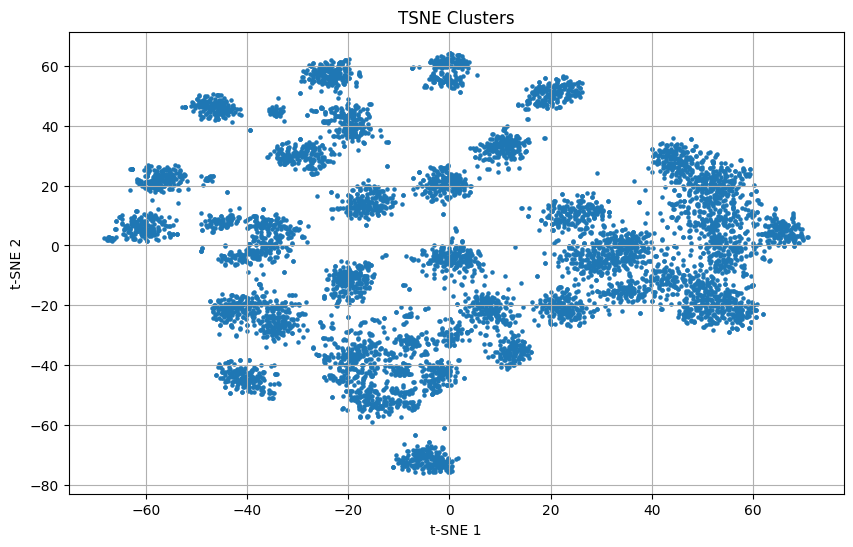

In [57]:
from sklearn.manifold import TSNE

TSNE = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
TSNE_embeddings = TSNE.fit_transform(res_breed_features)

plt.figure(figsize=(10, 6))
plt.scatter(TSNE_embeddings[:, 0], TSNE_embeddings[:, 1], s=5)
plt.title("TSNE Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()

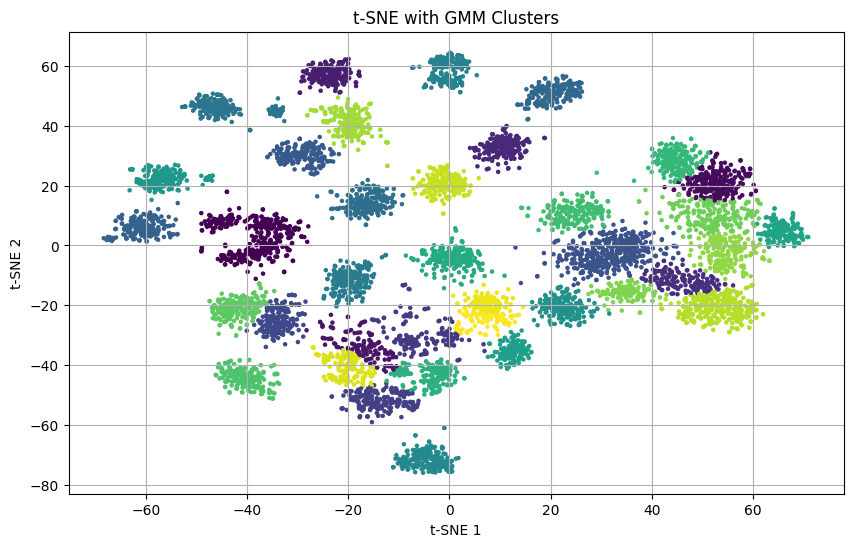

Silhouette Score TSNE: 0.45
Purity: 0.808


In [67]:
from sklearn.manifold import TSNE

TSNE = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
TSNE_embe = TSNE.fit_transform(res_breed_features)

plt.figure(figsize=(10, 6))
plt.scatter(TSNE_embe[:, 0], TSNE_embe[:, 1], c = GMM(TSNE_embe, 37), s=5)
plt.title("t-SNE with GMM Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()


silhouette_avg = silhouette_score(TSNE_embeddings, gmm)
print(f"Silhouette Score TSNE: {silhouette_avg:.2f}")
purity = purity_score(np.array(res_breed_labels_numeric), np.array(GMM(TSNE_embe, 37)))
print(f"Purity: {purity:.3f}")

C:\Users\Mohammed Ameen Dasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


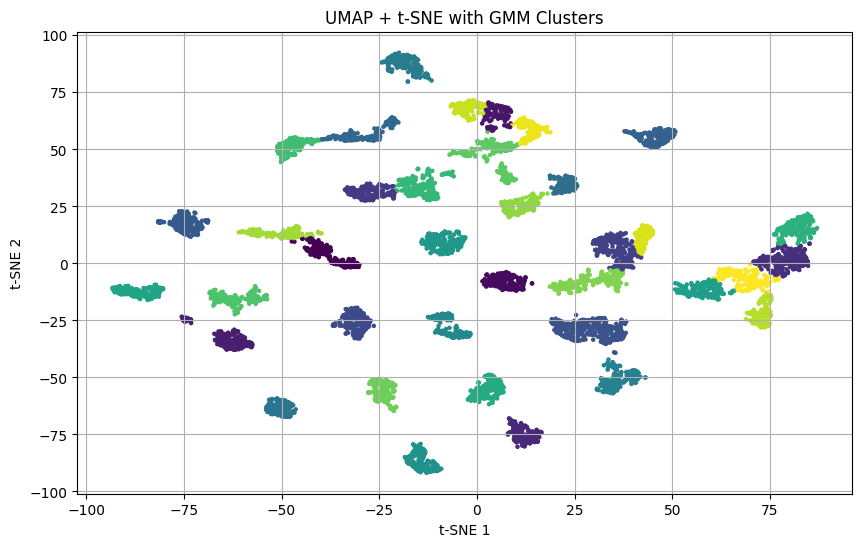

Silhouette Score TSNE + UMAP: 0.64
Purity: 0.820


In [59]:
import numpy as np
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Step 1: Apply UMAP
umap_reducer = umap.UMAP(n_neighbors=25, min_dist=0.5, n_components=300)
UMAP_embeddings = umap_reducer.fit_transform(res_breed_features)

# Step 2: Apply t-SNE to UMAP Output
tsne = TSNE(n_components=2, perplexity=50, learning_rate=1500)
TSNE_embeddings = tsne.fit_transform(UMAP_embeddings)

# Step 3: Perform Clustering
gmm = GMM(TSNE_embeddings, 37)

# Step 4: Visualise t-SNE Clusters
plt.figure(figsize=(10, 6))
plt.scatter(TSNE_embeddings[:, 0], TSNE_embeddings[:, 1], c=gmm, s=5)
plt.title("UMAP + t-SNE with GMM Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()

# Step 5: Evaluate Clustering with Silhouette Score
silhouette_avg = silhouette_score(TSNE_embeddings, gmm)
print(f"Silhouette Score TSNE + UMAP: {silhouette_avg:.2f}")
purity = purity_score(np.array(res_breed_labels_numeric), np.array(gmm))
print(f"Purity: {purity:.3f}")

## VGG 16 Breeds TSNE Clustering

C:\Users\Mohammed Ameen Dasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


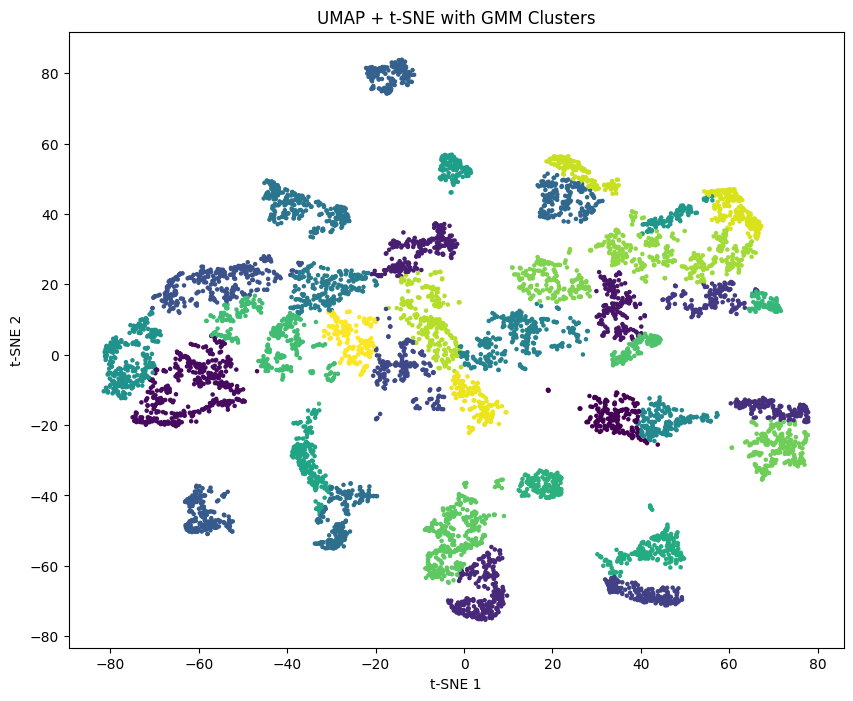

Silhouette Score TSNE + UMAP: 0.45
Purity: 0.508


In [60]:
import numpy as np
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Step 1: Apply UMAP
umap_reducer = umap.UMAP(n_neighbors=25, min_dist=0.5, n_components=300)
UMAP_embeddings = umap_reducer.fit_transform(vgg_features)

# Step 2: Apply t-SNE to UMAP Output
tsne = TSNE(n_components=2, perplexity=50, learning_rate=1500)
TSNE_embeddings = tsne.fit_transform(UMAP_embeddings)

# Step 3: Perform Clustering
gmm = GMM(TSNE_embeddings, 37)

# Step 4: Visualise t-SNE Clusters
plt.figure(figsize=(10, 8))
plt.scatter(TSNE_embeddings[:, 0], TSNE_embeddings[:, 1], c=gmm, cmap='viridis', s=5)
plt.title("UMAP + t-SNE with GMM Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

# Step 5: Evaluate Clustering with Silhouette Score
silhouette_avg = silhouette_score(TSNE_embeddings, gmm)
print(f"Silhouette Score TSNE + UMAP: {silhouette_avg:.2f}")
purity = purity_score(np.array(vgg_labels), np.array(gmm))
print(f"Purity: {purity:.3f}")

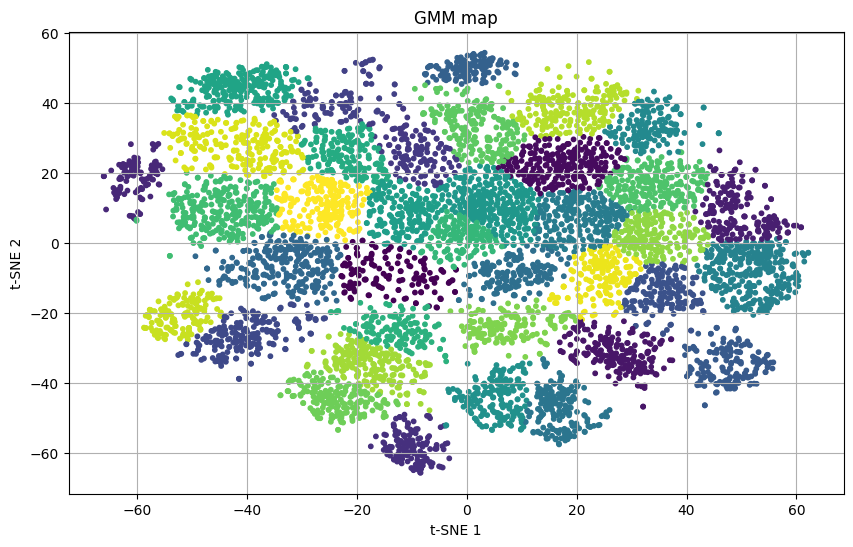

Silhouette Score TSNE: 0.18
Purity: 0.508


In [68]:
from sklearn.manifold import TSNE

TSNE = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
TSNE_embe = TSNE.fit_transform(vgg_features)

plot_clusters(TSNE_embe, GMM(TSNE_embe,37), 'GMM map', 't-SNE')


silhouette_avg = silhouette_score(TSNE_embe, gmm)
print(f"Silhouette Score TSNE: {silhouette_avg:.2f}")
purity = purity_score(np.array(vgg_labels), np.array(gmm))
print(f"Purity: {purity:.3f}")

# Accuracies (only 37 Breeds)

In [62]:
def evaluate(feature_extractor, fc_layer, dataloader):
    feature_extractor.eval()  # Set feature extractor to evaluation mode
    fc_layer.eval()           # Set fully connected layer to evaluation mode
    correct_predictions = 0

    with torch.no_grad():  # No gradient calculations needed
        for images, labels in dataloader:
            # Move images and labels to the device
            images, labels = images.to(device), labels.to(device)

            # Extract features using the feature extractor
            features = feature_extractor(images)
            features = features.flatten(start_dim=1)  # Flatten the features

            # Forward pass through the FC layer
            outputs = fc_layer(features)
            _, preds = torch.max(outputs, 1)  # Get predicted class
            correct_predictions += torch.sum(preds == labels)  # Compare with true labels

    # Calculate accuracy
    accuracy = correct_predictions.double() / len(dataloader.dataset)
    print(f'SVM Test Accuracy on trained Features: {accuracy:.4f}')
    return accuracy.item()

def train_and_evaluate_svm(features, labels, test_size=0.2, kernel='linear', C=1.0, random_state=42):

    # Convert labels to numeric indices
    label_to_index = {label: idx for idx, label in enumerate(set(labels))}
    numeric_labels = [label_to_index[label] for label in labels]

    # Split features and labels into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, numeric_labels, 
                                                        test_size=test_size, 
                                                        random_state=random_state)

    # Train an SVM classifier
    svm = SVC(kernel=kernel, C=C, random_state=random_state)
    svm.fit(X_train, y_train)

    # Predict on the test set
    y_pred = svm.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"SVM Accuracy on extracted features: {accuracy:.4f}")
    
    return accuracy

## Resnet 18 - Accuracies

### Before Training

In [63]:
test_accuracy = train_and_evaluate_svm(res_breed_features, res_breed_labels)

SVM Accuracy on extracted features: 0.9026


### After Training

In [64]:
feature_extractor_resnet = feature_extractor_resnet.to(device)
fc_layer = fc_layer.to(device)  # Ensure the FC layer is on the same device
test_accuracy = evaluate(feature_extractor_resnet, fc_layer, test_loader_Breeds)

SVM Test Accuracy on trained Features: 0.9723


NameError: name 'test_acuracy' is not defined

## VGG - 16 - Accuracies

### Before Training

In [65]:
test_accuracy = train_and_evaluate_svm(vgg_features, vgg_labels)

SVM Accuracy on extracted features: 0.9093


### After Training

In [72]:
feature_extractor_vgg = feature_extractor_vgg.to(device)
vgg_layer = vgg_layer.to(device)  # Ensure the FC layer is on the same device


test_accuracy = evaluate(feature_extractor_vgg, vgg_layer, test_loader_Breeds)

SVM Test Accuracy on trained Features: 0.9892


# Fin